In [56]:
from androguard.misc import AnalyzeAPK
import os
import matplotlib
import pandas as pd

In [36]:
# https://apkcombo.com/colornote/com.socialnmobile.dictapps.notepad.color.note/download/apk
test_apk = os.path.abspath('./APKs/color_note.apk')

apk,dex,analysis = AnalyzeAPK(test_apk)

Requested API level 31 is larger than maximum we have, returning API level 28 instead.


      0
0     8
1  8142
2  4138
3  2350
4  2027
5  1481
6  1049
7   768
8   861
9  2346


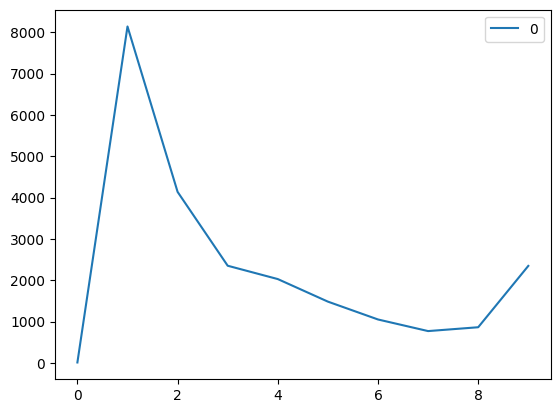

In [69]:
from collections import Counter
from math import floor, log10

def first_digit_len(x):
    l = len(x)
    if l == 0:
        return 0
    return floor(l / (10 ** floor(log10(l))))

strings = dex[0].get_strings()

strings = list(map(str.strip, strings))

counter = pd.DataFrame.from_dict(Counter(list(map(first_digit_len, strings))), orient='index').sort_index()

counter.plot(kind='line', y=0)

print(counter)